# Validation of the PyPSA-Africa Installed capacity

This notebooks investigates the data quality of the African electric consumption
data by comparing PyPSA, official Nigerian and [IRENA statistics](https://pxweb.irena.org/pxweb/en/IRENASTAT/IRENASTAT__Power%20Capacity%20and%20Generation/ELECCAP_2022_cycle2.px/).

To reproduce the findings obtained in this notebook,
please run the full snakemake workflow for Nigeria.
To do so, please set ``countries = ["NG"]`` in the ``config.yaml`` file. We aim to validate the models for every country, so feel free to reproduce this notebook with a country of ypour choice.

Note. An unoptimized prepared network is sufficient for this notebook. 

## Preparation

### Import packages

In [1]:
# import packages

import logging
import os

import pypsa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

### Set main directory to root folder

In [2]:
# change current directory
import os
import sys

module_path = os.path.abspath(os.path.join('../../../')) # To import helpers
if module_path not in sys.path:
    sys.path.append(module_path+"/pypsa-earth/scripts")
    
from _helpers import sets_path_to_root, country_name_2_two_digits, two_digits_2_name_country

sets_path_to_root("pypsa-earth-project")

This is the repository path:  /home/anas/EDF/pypsa-earth-project
Had to go 3 folder(s) up.


## 1. Load data 

#### IRENA data
Retrieved from [IRENA statistics](https://pxweb.irena.org/pxweb/en/IRENASTAT/IRENASTAT__Power%20Capacity%20and%20Generation/ELECCAP_2022_cycle2.px/).\
Please, download the statistics for 2020 for all the world and specify the url specified above, saving it to pypsa-earth-project/documentation, and changing the file name in the script to match the downloaded file.

In [3]:
year_select = 2020

IRENA_path = os.getcwd() + "/documentation/ELECCAP_20221114-003641.csv"
df_irena = pd.read_csv(IRENA_path, skiprows=2, encoding="latin-1")
df_irena = df_irena[df_irena.loc[:, "Year"] == year_select]
df_irena = df_irena.iloc[:, [0, 1, 2, 4]]
# df = df[df["iso_code"].notna()]  # removes antartica
df_irena["alpha2"] = df_irena.loc[:, "Country/area"].apply(
    lambda x: country_name_2_two_digits(x)
)
# electricity_demand_owid = df
# electricity_demand_owid.tail(2)

#### PyPSA generator data

Loads the PyPSA generators data

##### Load data from the network and create normalized dataframe

In [4]:
addelectricity_network_path = os.getcwd() + "/pypsa-earth/networks/elec.nc"
pypsa_network = pypsa.Network(addelectricity_network_path)

# statistics of non-storage units
installed_capacity_nostorages = pypsa_network.generators.copy()
# add country column
installed_capacity_nostorages["alpha2"] = installed_capacity_nostorages.bus.map(
    lambda x: pypsa_network.buses.country.loc[x]
)
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"].isin(["ror"]), "carrier"
] = "hydro"
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"] == "onwind", "carrier"
] = "onshore wind"
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"].isin(["offwind-ac", "off-shore-dc"]),
    "carrier",
] = "offshore wind"
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"].isin(["CCGT", "OCGT"]), "carrier"
] = "gas"
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"] == "onwind", "carrier"
] = "wind"
installed_capacity_nostorages_select = installed_capacity_nostorages.loc[
    :, ["alpha2", "carrier", "p_nom"]
]

# statistics of storage units
installed_capacity_storages = pypsa_network.storage_units.copy()
# add country column
installed_capacity_storages["alpha2"] = installed_capacity_storages.bus.map(
    lambda x: pypsa_network.buses.country.loc[x]
)
installed_capacity_storages.loc[
    installed_capacity_storages["carrier"] == "PHS", "carrier"
] = "hydro"
installed_capacity_storages_select = installed_capacity_storages.loc[
    :, ["alpha2", "carrier", "p_nom"]
]


installed_capacity_raw = pd.concat(
    [installed_capacity_storages_select, installed_capacity_nostorages_select]
)
installed_capacity = installed_capacity_raw.groupby(["alpha2", "carrier"])[
    "p_nom"
].sum()
installed_capacity.groupby("carrier").sum()

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers


carrier
gas             6637.628701
hydro           1905.414013
oil             1190.420799
onshore wind       2.373673
solar             27.933465
Name: p_nom, dtype: float64

##### Load PyPSA powerplant data to crosscheck data from the network

In [5]:
powerplants_data = os.getcwd() + "/pypsa-earth/resources/powerplants.csv"
available_generators = pd.read_csv(powerplants_data)
installed_capacity_resources = available_generators.groupby(["Country", "Fueltype"])[
    "Capacity"
].sum()
installed_capacity_resources.groupby(["Fueltype"]).sum()

Fueltype
CCGT      450.000000
Hydro    1905.414013
OCGT     6187.628701
Oil      1190.420799
Name: Capacity, dtype: float64

# 2. Validate

#### Steps:
- Specify year of interest of the IRENA dataset and the countries of interest
- Harmonize IRENA dataset to the PyPSA standard
- Align dataframe naming and temporal resolution
- Merge dataframe


##### Specify year of the analysis and the countries of interest

In [6]:
year_owid = 2020  # option
country_list = installed_capacity_nostorages.alpha2.unique()
country_list

array(['NG'], dtype=object)

##### Process IRENA data to match PyPSA standard

In [7]:
# copy IRENA dataset
df = df_irena.copy()

# Process technologies
df.loc[
    df["Technology"].isin(["Solar photovoltaic", "Solar thermal energy"]), "Technology"
] = "solar"
df.loc[df["Technology"].isin(["Onshore wind energy"]), "Technology"] = "onshore wind"
df.loc[df["Technology"].isin(["Offshore wind energy"]), "Technology"] = "offshore wind"
df.loc[
    df["Technology"].isin(
        ["Renewable hydropower", "Mixed Hydro Plants", "Pumped storage"]
    ),
    "Technology",
] = "hydro"
df.loc[
    df["Technology"].isin(["Other non-renewable energy", "Marine energy"]), "Technology"
] = "other"
df.loc[
    df["Technology"].isin(["Liquid biofuels", "Biogas", "Solid biofuels"]), "Technology"
] = "bioenergy"
df.loc[df["Technology"].isin(["Geothermal energy"]), "Technology"] = "geothermal"
df.loc[df["Technology"].isin(["Natural gas"]), "Technology"] = "gas"
df.loc[df["Technology"].isin(["Renewable municipal waste"]), "Technology"] = "waste"
df.loc[df["Technology"].isin(["Coal and peat"]), "Technology"] = "coal"
df.loc[df["Technology"].isin(["Oil", "Fossil fuels n.e.s."]), "Technology"] = "oil"


df = df[df.alpha2.isin(country_list)]
df["p_nom"] = pd.to_numeric(
    df["Installed electricity capacity by country/area (MW)"], errors="coerce"
)
installed_capacity_irena = (
    df.rename(columns={"Technology": "carrier"})
    .groupby(["alpha2", "carrier"])["p_nom"]
    .sum()
)
# installed_capacity_irena.groupby("carrier").sum()

##### Merge datasets by carrier

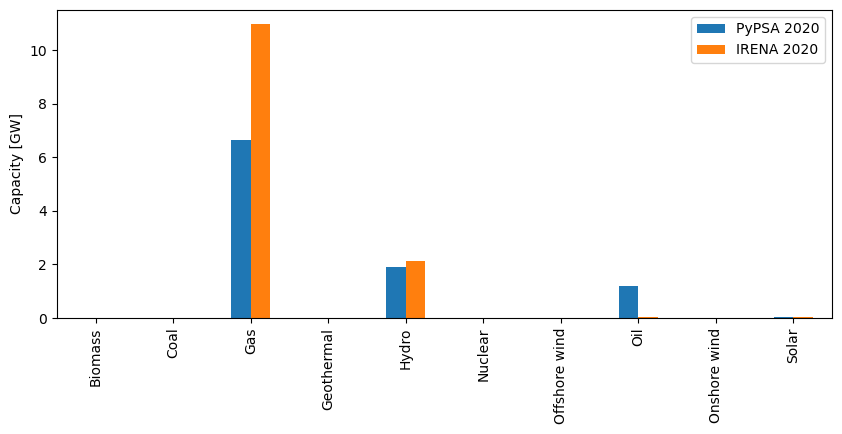

In [8]:
world_ic = installed_capacity_irena.groupby("carrier").sum() / 1000
world_ic = world_ic.rename(index={"bioenergy": "Biomass"})

world_ic.index = world_ic.index.str.capitalize()

world_pypsa = installed_capacity.groupby("carrier").sum() / 1000
if "load" in world_pypsa.index:
    world_pypsa = world_pypsa.drop("load")
world_pypsa.index = world_pypsa.index.str.capitalize()

world_compare = pd.concat(
    [world_pypsa.rename("PyPSA 2020"), world_ic.rename("IRENA 2020")], axis=1
)

# Sorting and dropping
world_compare = world_compare.drop("Waste")
world_compare = world_compare.drop("Other")
world_compare = world_compare.sort_index()

# Plot
ax = world_compare.plot.bar(
    ylabel="Capacity [GW]", xlabel="Technology", figsize=(10, 4)
).set(xlabel=None)

# plt.savefig("capacity-validation-all.pdf", bbox_inches="tight")

[Text(0.5, 0, '')]

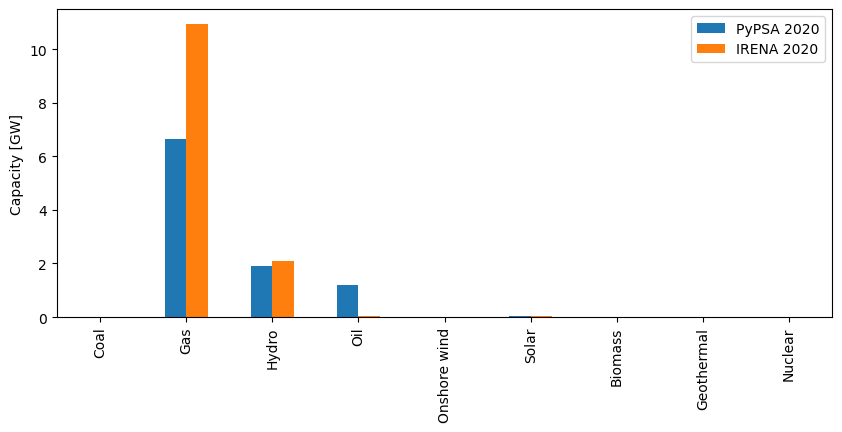

In [9]:
list_carriers = [
    "Coal",
    "Gas",
    "Hydro",
    "Oil",
    "Onshore wind",
    "Solar",
    "Biomass",
    "Geothermal",
    "Nuclear",
]

world_compare.loc[list_carriers].plot.bar(
    ylabel="Capacity [GW]", xlabel="Technology", figsize=(10, 4)
).set(xlabel=None)

# plt.savefig("capacity-validation.pdf", bbox_inches="tight")

##### Merge dataframes by technology for specific country

According to [USAID](https://www.usaid.gov/powerafrica/nigeria), the total installed generation in Nigeria is:
- Hydro: 2.062 GW
- Gas: 11.972 GW
- Wind: 0.01 GW
- Solar: 0.007 GW
- Other/Diesel/HFO: 2.333 GW

Total: 16.384 GW

Power Africa new MW to date at financial close: 3.043 GW

In [10]:
# Get data from usaid manually
usaid_ng = pd.DataFrame(
    data=[2.062, 11.972, 0.01, 0.007, 2.333],
    index=["Hydro", "Gas", "Wind", "Solar", "Other/Diesel/HFO"],
    columns=["USAID"],
)

# Prepare data from usaid
usaid_ng.index.name = "carrier"

usaid_ng.rename(
    index={
        "Hydro": "hydro",
        "Gas": "gas",
        "Wind": "wind",
        "Solar": "solar",
        "Other/Diesel/HFO": "oil",
    },
    inplace=True,
)
print("WARNING: Other/Diesel/HFO is renamed to 'Oil'")

In [11]:
country = "NG"
country_ic = (
    installed_capacity_irena.iloc[
        installed_capacity_irena.index.get_level_values("alpha2") == country
    ]
    / 1000
)
country_pypsa = (
    installed_capacity.iloc[
        installed_capacity.index.get_level_values("alpha2") == country
    ]
    / 1000
)
country_compare = pd.concat(
    [country_pypsa.rename("PyPSA 2020"), country_ic.rename("IRENA 2020")], axis=1
)
country_compare.index = country_compare.index.get_level_values(1)
country_compare = pd.concat([country_compare, usaid_ng], axis=1)

Adjust the dataframe

In [12]:
# Rename the index according to existing graph in paper
required_index = {
    # "coal": "Coal",
    "gas": "Gas",
    "hydro": "Hydro",
    "oil": "Oil",
    "wind": "Onshore wind",
    "solar": "Solar",
    # "Nuclear": "Nuclear",
    # "bioenergy": "Bioenergy",
    # "geothermal": "Geothermal",
}

country_compare.rename(index=required_index, inplace=True)

# select only required technologies
country_compare_sel = country_compare.loc[list(required_index.values())]

Plot the graph

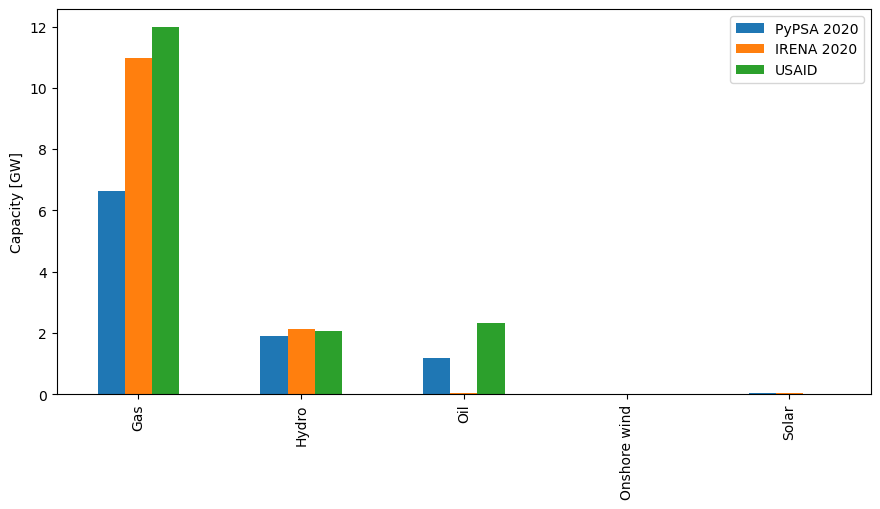

In [13]:
ax = country_compare_sel.plot.bar(ylabel="Capacity [GW]", xlabel="", figsize=(10.5, 5))
# optional:save it
# ax.figure.savefig("capacity-validation-ng.pdf", bbox_inches="tight")

##### Merge dataframes by country

[Text(0.5, 0, '')]

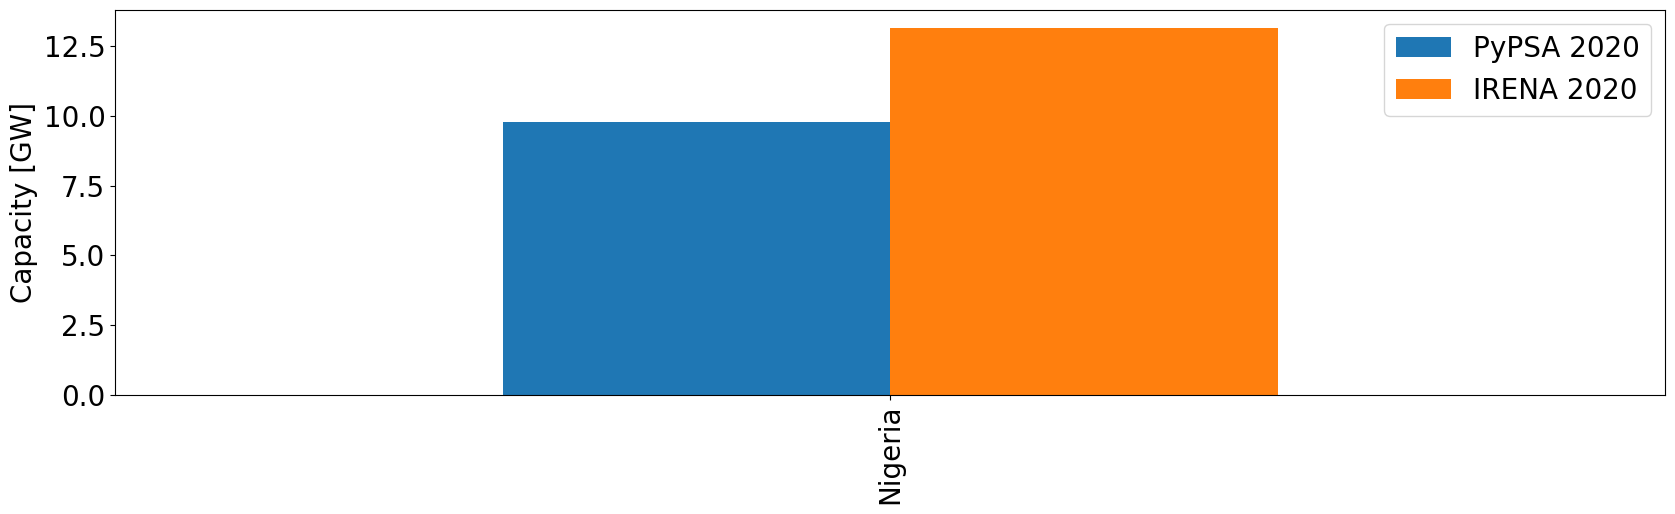

In [14]:
country_ic = (
    installed_capacity_irena[
        installed_capacity_irena.index.get_level_values(1)
        .str.capitalize()
        .isin(list_carriers)
    ]
    .groupby("alpha2")
    .sum()
    / 1000
)
country_pypsa = (
    installed_capacity[
        installed_capacity.index.get_level_values(1)
        .str.capitalize()
        .isin(list_carriers)
    ]
    .groupby("alpha2")
    .sum()
    / 1000
)

country_compare = pd.concat(
    [country_pypsa.rename("PyPSA 2020"), country_ic.rename("IRENA 2020")], axis=1
)
country_compare.index = pd.Series(
    country_compare.index.map(two_digits_2_name_country)
).replace(
    {
        "Congo, The Democratic Republic of the": "DRC",
        "Central African Republic": "CAR",
        "Tanzania, United Republic of": "Tanzania",
    }
)
plt.rcParams.update({"font.size": 20})
ax = country_compare.plot.bar(
    figsize=(20, 5), ylabel="Capacity [GW]", xlabel="Country", fontsize=20
)
ax.set(xlabel=None)

# plt.savefig("capacity-validation-by-country.pdf", bbox_inches="tight")

In [15]:
# Installed capacities of a technology by country
# df[df.Technology=="gas"].groupby("alpha2")["p_nom"].sum()
# installed_capacity_nostorages_select[installed_capacity_nostorages_select.carrier == "gas"].groupby("alpha2")["p_nom"].sum()

# SEABORN

In [16]:
# Initialize the matplotlib figure
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
world_compare = world_compare.copy()
world_compare = world_compare.reset_index()

pypsa_values = world_compare.loc[:, ["carrier", "PyPSA 2020"]]
pypsa_values.loc[:, "sources"] = "PyPSA 2020"
pypsa_values.rename(columns={"PyPSA 2020": "capacity [GW]"}, inplace=True)

irena_values = world_compare.loc[:, ["carrier", "IRENA 2020"]]
irena_values.loc[:, "sources"] = "IRENA 2020"
irena_values.rename(columns={"IRENA 2020": "capacity [GW]"}, inplace=True)

seaborn_df = pd.concat([pypsa_values, irena_values])

#### Calculate percentage error of technologies

In [18]:
pypsa_values.set_index("carrier")["capacity [GW]"] / irena_values.set_index("carrier")[
    "capacity [GW]"
]

carrier
Biomass                NaN
Coal                   NaN
Gas               0.605678
Geothermal             NaN
Hydro             0.902698
Nuclear                NaN
Offshore wind          NaN
Oil              27.878707
Onshore wind           inf
Solar             0.982604
Name: capacity [GW], dtype: float64

#### Plot technology map

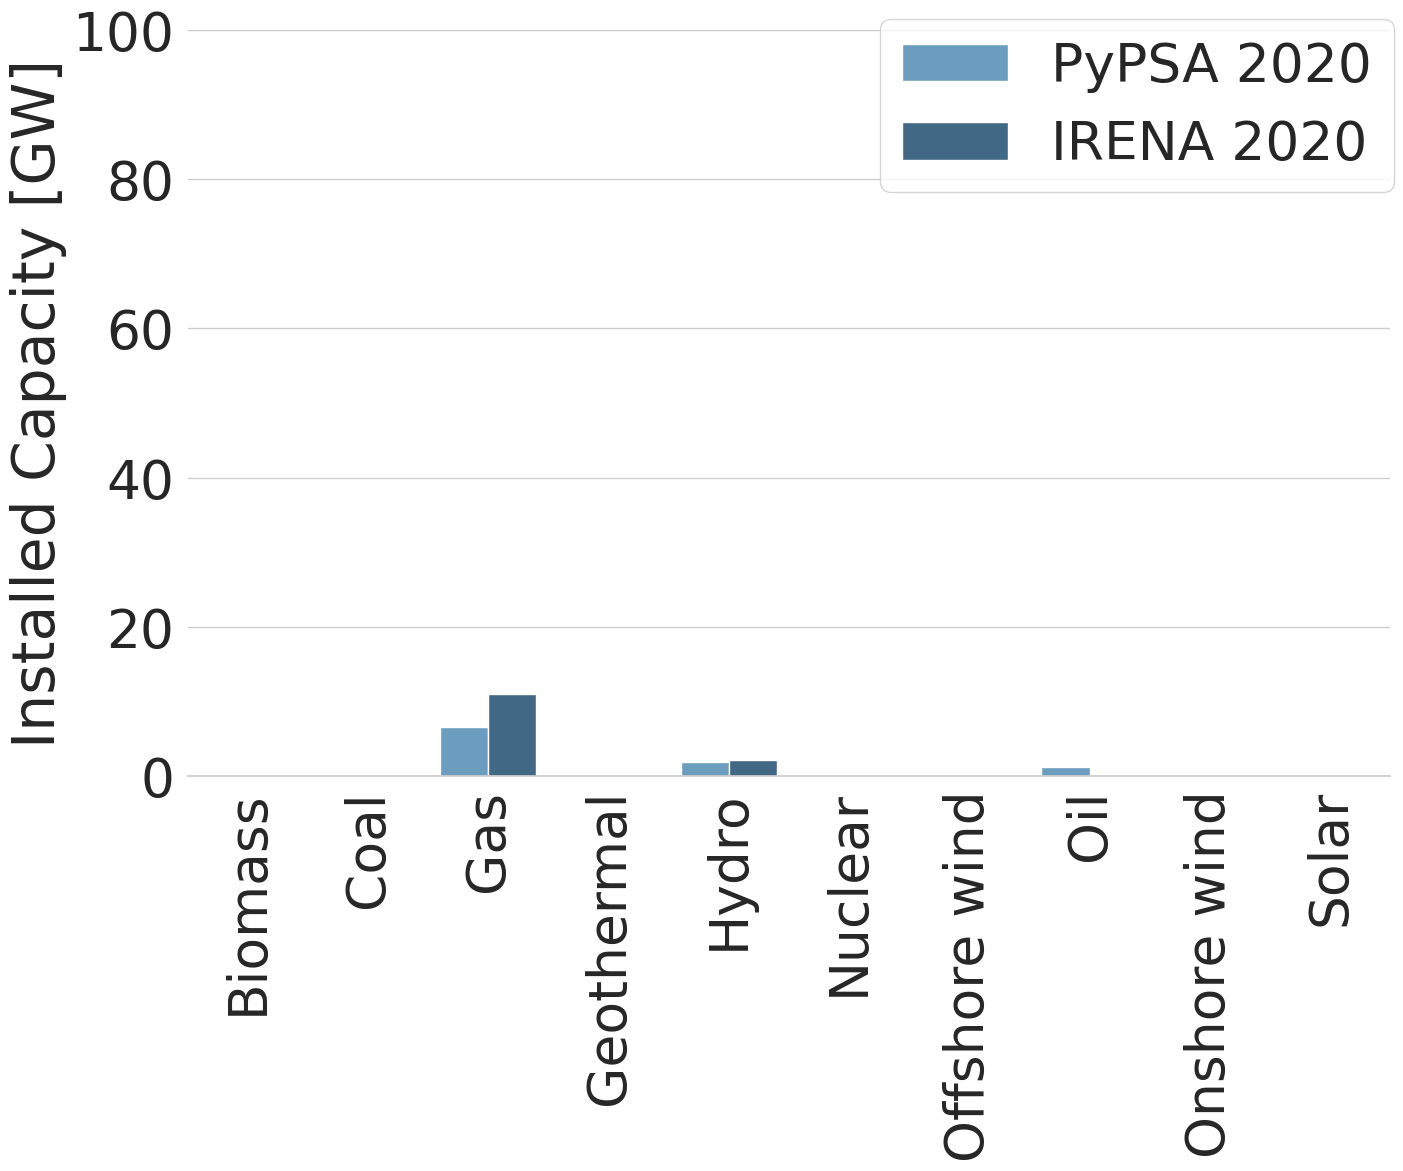

In [19]:
sns.set_theme(style="whitegrid", font_scale=3.5)

ax = sns.catplot(
    x="carrier",
    y="capacity [GW]",
    hue="sources",
    data=seaborn_df,
    palette="Blues_d",
    kind="bar",
    height=10,
    aspect=1.5,
)

ax.set_xticklabels(rotation=90)
sns.move_legend(
    ax, "upper right", bbox_to_anchor=(0.75, 0.975), frameon=True, title=None
)
sns.despine(left=True, bottom=False)
ax.set(xlabel=None, ylabel="Installed Capacity [GW]", ylim=(0, 100))

# plt.savefig("capacity-validation-all.pdf", bbox_inches="tight")

In [20]:
country_compare_sel = country_compare_sel.copy()
country_compare_sel = country_compare_sel.reset_index()

pypsa_values = country_compare_sel.loc[:, ["carrier", "PyPSA 2020"]]
pypsa_values.loc[:, "sources"] = "PyPSA 2020"
pypsa_values.rename(columns={"PyPSA 2020": "capacity [GW]"}, inplace=True)

irena_values = country_compare_sel.loc[:, ["carrier", "IRENA 2020"]]
irena_values.loc[:, "sources"] = "IRENA 2020"
irena_values.rename(columns={"IRENA 2020": "capacity [GW]"}, inplace=True)

usaid_values = country_compare_sel.loc[:, ["carrier", "USAID"]]
usaid_values.loc[:, "sources"] = "USAID 2020"
usaid_values.rename(columns={"USAID": "capacity [GW]"}, inplace=True)

seaborn_df = pd.concat([pypsa_values, irena_values, usaid_values])

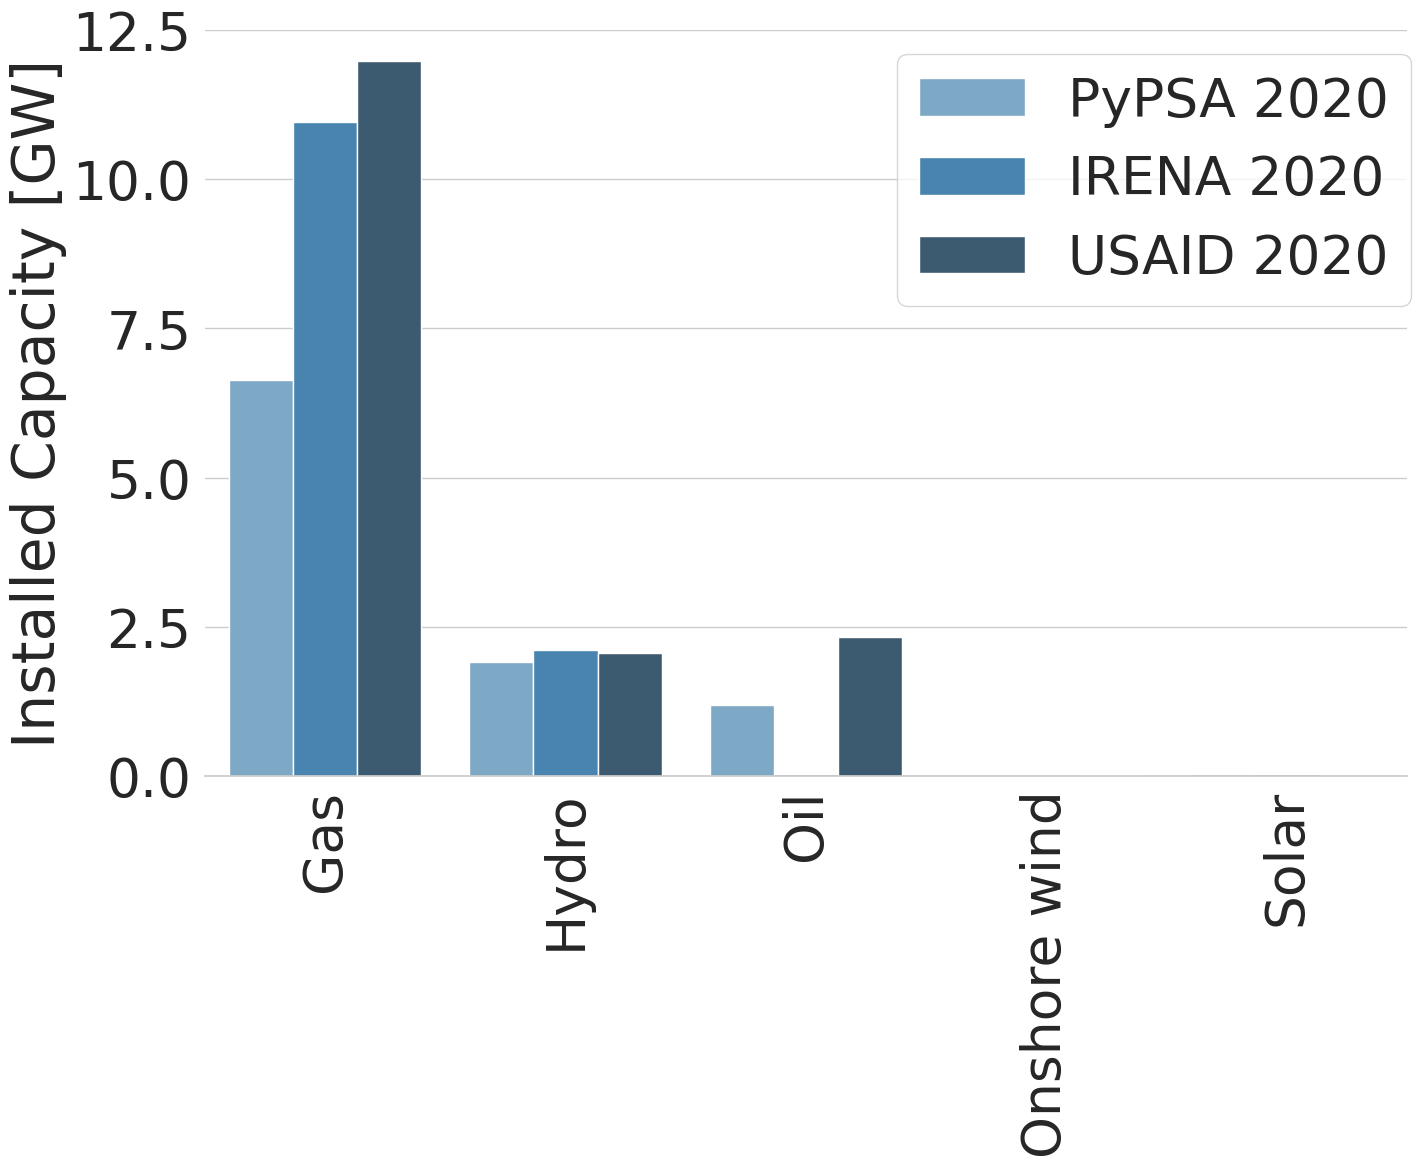

In [21]:
sns.set_theme(style="whitegrid", font_scale=3.5)

ax = sns.catplot(
    x="carrier",
    y="capacity [GW]",
    hue="sources",
    data=seaborn_df,
    palette="Blues_d",
    kind="bar",
    height=10,
    aspect=1.5,
)

ax.set_xticklabels(rotation=90)
sns.move_legend(
    ax, "upper right", bbox_to_anchor=(0.75, 0.94), frameon=True, title=None
)
sns.despine(left=True, bottom=False)
ax.set(xlabel=None, ylabel="Installed Capacity [GW]", ylim=(0, 12.5))

# plt.savefig("capacity-validation-ng.pdf", bbox_inches="tight")

In [22]:
country_compare = country_compare.copy()
country_compare = country_compare.reset_index()

pypsa_values = country_compare.loc[:, ["alpha2", "PyPSA 2020"]]
pypsa_values.loc[:, "sources"] = "PyPSA 2020"
pypsa_values.rename(columns={"PyPSA 2020": "capacity [GW]"}, inplace=True)

irena_values = country_compare.loc[:, ["alpha2", "IRENA 2020"]]
irena_values.loc[:, "sources"] = "IRENA 2020"
irena_values.rename(columns={"IRENA 2020": "capacity [GW]"}, inplace=True)

seaborn_df = pd.concat([pypsa_values, irena_values])

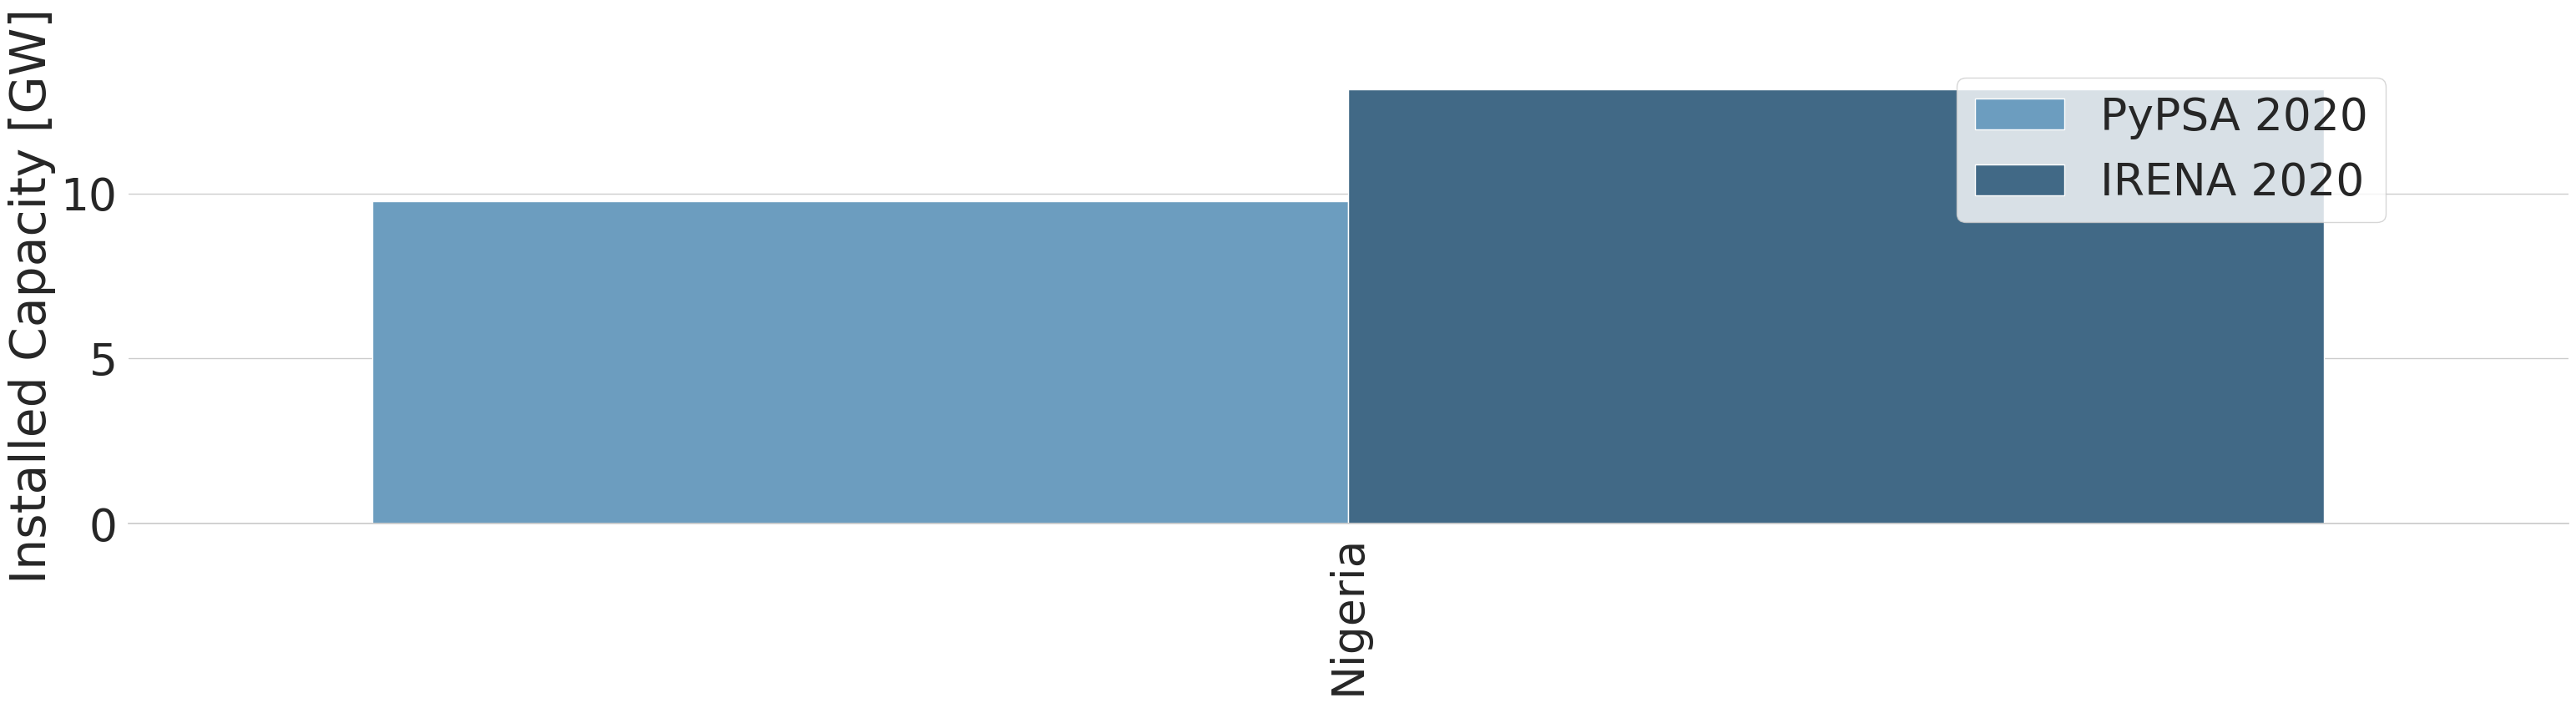

In [23]:
sns.set_theme(style="whitegrid", font_scale=3.5)

ax = sns.catplot(
    x="alpha2",
    y="capacity [GW]",
    hue="sources",
    data=seaborn_df,
    palette="Blues_d",
    kind="bar",
    height=8,
    aspect=4,
)

ax.set_xticklabels(rotation=90)
sns.move_legend(ax, "upper right", bbox_to_anchor=(0.8, 0.94), frameon=True, title=None)
sns.despine(left=True, bottom=False)
ax.set(xlabel=None, ylabel="Installed Capacity [GW]")

# plt.savefig("capacity-validation-by-country.pdf", bbox_inches="tight")